In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from LeNet import LeNet
from tqdm import tqdm_notebook
from torch.autograd import Variable

import numpy as np
import os

from sklearn import metrics

import matplotlib.pyplot as plt

# 可视化函数

In [13]:
# 可视化数据集
def imshow(img):
    img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()
def imshow_un(img):
#     img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# 攻击方法

In [82]:
import torch


#  FGSM攻击
class FGSM:
    def __init__(self, model, criterion, epsilon):
        self.model = model
        self.criterion = criterion
        self.epsilon = epsilon
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        assert isinstance(model, torch.nn.Module), "Input parameter model is not nn.Module. Check the model"
        assert isinstance(criterion, torch.nn.Module), "Input parameter criterion is no Loss. Check the criterion"
        assert (0 <= epsilon <= 1), "episilon must be 0 <= epsilon <= 1"
        self.model.eval()


    def __call__(self, input, labels):
        # For calculating gradient
        input_for_gradient = Variable(input, requires_grad=True).to(self.device)
        out = self.model(input_for_gradient)
        loss = self.criterion(out, Variable(labels))

        # Calculate gradient
        loss.backward()

        # Calculate sign of gradient
        signs = torch.sign(input_for_gradient.grad.data)

        # Add
        input_for_gradient.data = input_for_gradient.data + (self.epsilon * signs)

        return input_for_gradient, signs
    
class FGSM_local:
    def __init__(self, model, criterion, epsilon):
        self.model = model
        self.criterion = criterion
        self.epsilon = epsilon
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        assert isinstance(model, torch.nn.Module), "Input parameter model is not nn.Module. Check the model"
        assert isinstance(criterion, torch.nn.Module), "Input parameter criterion is no Loss. Check the criterion"
        assert (0 <= epsilon <= 1), "episilon must be 0 <= epsilon <= 1"
        self.model.eval()


    def __call__(self, input, labels):
        # For calculating gradient
        input_for_gradient = Variable(input, requires_grad=True).to(self.device)
        out = self.model(input_for_gradient)
        loss = self.criterion(out, Variable(labels))

        # Calculate gradient
        loss.backward()

        # Calculate sign of gradient
        signs = torch.sign(input_for_gradient.grad.data)
        
        size = signs.shape[-1] // 4
        mask = torch.zeros_like(signs)
        mask[:,:,0:size,0:size] = 1
        signs = signs.mul(mask)
        
        # Add
        input_for_gradient.data = input_for_gradient.data + (self.epsilon * signs)

        return input_for_gradient, signs, mask

# 读取数据集

In [7]:
trans = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST(root='D:/dataset/MNIST', train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root='D:/dataset/MNIST', train=False, download=True, transform=trans)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 读取被攻击模型

In [9]:
model = LeNet()
model.load_state_dict(torch.load('./model/LeNet_MNIST.pt'))
model = model.to(device)

# 攻击样本

In [10]:
epsilon = 0.3
criterion = nn.CrossEntropyLoss()

fgsm = FGSM(model, criterion, epsilon)

In [11]:
# 准备模型
model.eval()
test_loss = 0
correct = 0

# 遍历数据集
target_arr = []
output_arr = []

for data, target in tqdm_notebook(test_loader):
    data, target = data.to(device), target.to(device)

    data, sign = fgsm(data, target)

    output = model(data)
    test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

    target_arr.append(target.cpu().data.numpy())
    output_arr.append(output.cpu().data.numpy())
    
    
test_loss /= len(test_loader.dataset)
    
print('test loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )


test loss: {3.0216}
correct: {0.0543}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


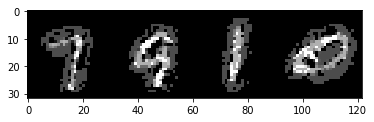

In [18]:
imshow_un(torchvision.utils.make_grid(data.cpu().detach()))

# 局部攻击

In [19]:
iterater = iter(test_loader)

In [20]:
sample_X, sample_Y = iterater.next()

In [21]:
epsilon = 0.3
criterion = nn.CrossEntropyLoss()
fgsm = FGSM(model, criterion, epsilon)

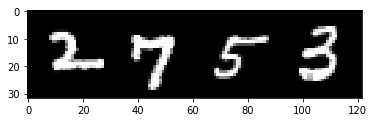

In [35]:
imshow_un(torchvision.utils.make_grid(sample_X))

In [23]:
data,sign = fgsm(sample_X.to(device), sample_Y.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


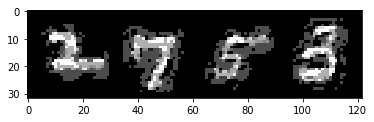

In [34]:
imshow_un(torchvision.utils.make_grid(data.cpu().detach()))

In [83]:
# local attack
epsilon = 1
criterion = nn.CrossEntropyLoss()

fgsm_local = FGSM_local(model, criterion, epsilon)

In [84]:
data, sign,mask = fgsm_local(sample_X.to(device), sample_Y.to(device))
output = model(data)
pred = output.argmax(dim=1)
print('label:{}'.format(sample_Y))
print('adv pred:{}'.format(pred))

label:tensor([2, 7, 5, 3])
adv pred:tensor([2, 7, 5, 3], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


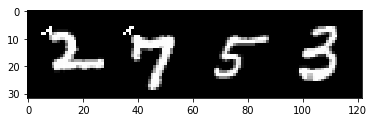

In [85]:
imshow_un(torchvision.utils.make_grid(data.cpu().detach()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


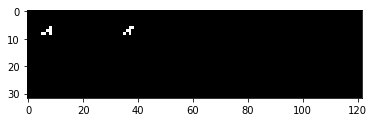

In [86]:
imshow_un(torchvision.utils.make_grid(sign.cpu()))

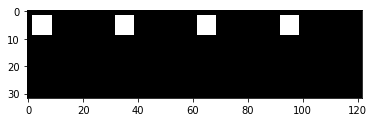

In [87]:
imshow_un(torchvision.utils.make_grid(mask.cpu()))